# SIV PROJECT - CLASSIFICATION OF SHIP FROM SAR IMAGES

## PRE-PROCESSING PHASE


In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os 
import random
import glob

## Util functions

Utility functions used in the notebook

In [2]:
from skimage import img_as_float

# Show multiple images
def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)

# function to take a random file from the folder and applying canny transformation
def get_random_jpg_file(jpg_files):
    if not jpg_files:
        print("No jpg files found in the folder.")
        return None

    random_jpg = random.choice(jpg_files)

    return os.path.join(random_jpg)

## Displaying images
Description about dataset and images

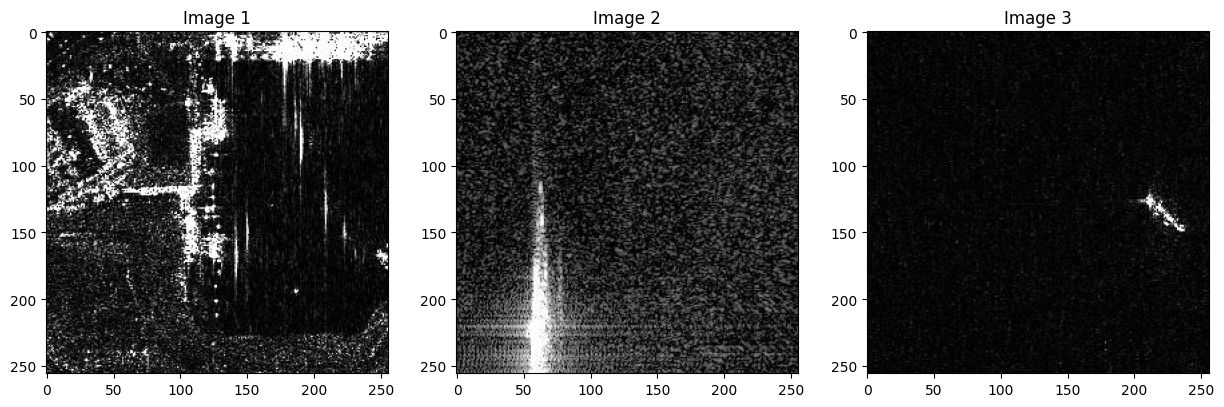

In [3]:
BASE_DIR = './ship_dataset_v0/'

# Replace 'path/to/directory' with the directory path where your .jpg files are located
jpg_files = glob.glob(BASE_DIR +'*.jpg')

# Display n random images from the dataset
# TODO: show also the txt files
n_times = 3
images = []
titles = []
for i in range(n_times):
    random_img = get_random_jpg_file(jpg_files)
    if not random_img:
        break
    img = cv2.imread(random_img)
    title = f'Image {i+1}'
    images.append(img)
    titles.append(title)
    
imshow_all(*images, titles=titles)

## Noise Reduction

We took a sample image, converted it in grayscale and tried different techniques to reduce noise.

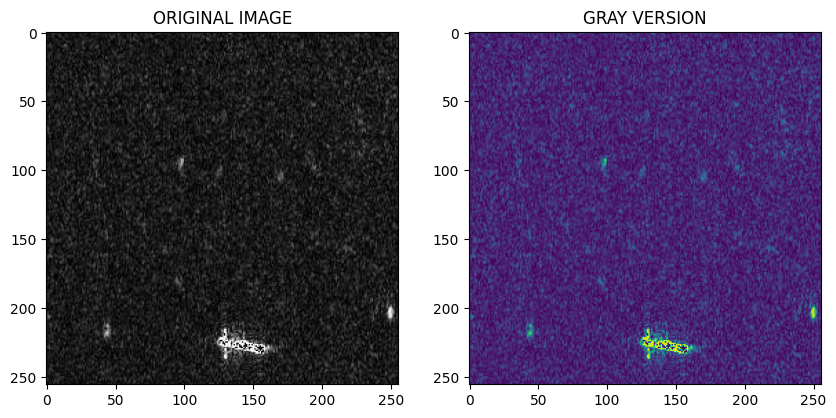

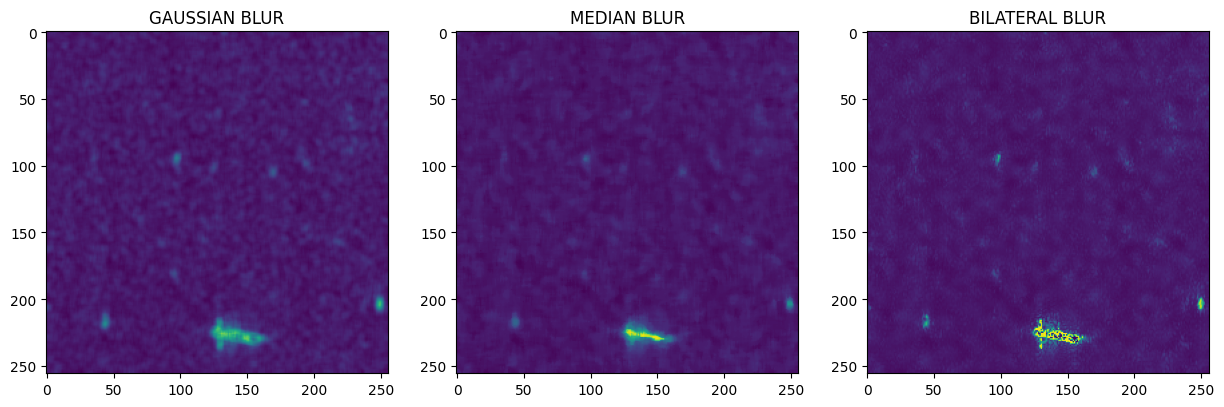

In [58]:
# file_jpg = BASE_DIR + 'ship030608' + '.jpg'
file_jpg = get_random_jpg_file(jpg_files)
img = cv2.imread(file_jpg)

# gaussian is not good for what we want to achieve, we need to enchance the bright colors...
# imshow_all(example_image, filters.sobel(example_image), filters.gaussian(example_image), titles=["ORIGINAL IMAGE", "SOBEL FILTER", "GAUSSIAN FILTER"])

# from 3 to 1 channel to reduce complexity
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imshow_all(img, gray, titles=["ORIGINAL IMAGE",  "GRAY VERSION"])

gaussian_blur = cv2.GaussianBlur(gray, (5, 5), cv2.BORDER_DEFAULT)

median_blur = cv2.medianBlur(gray, 7)

bilateral_blur = cv2.bilateralFilter(gray, 10, 35, 25)

imshow_all(gaussian_blur, median_blur, bilateral_blur, titles=["GAUSSIAN BLUR",  "MEDIAN BLUR", "BILATERAL BLUR"])

# we want also to precise in the shore since the difficulty to detect sea and land and then performing the classification comes from that

## Edge Detection

We used Canny method to detect edges in the image.

./ship_dataset_v0\Gao_ship_hv_020180201890508021.txt
Contents of the file:
0 0.537109375 0.876953125 0.19140625 0.08203125

The ships in the file are 1


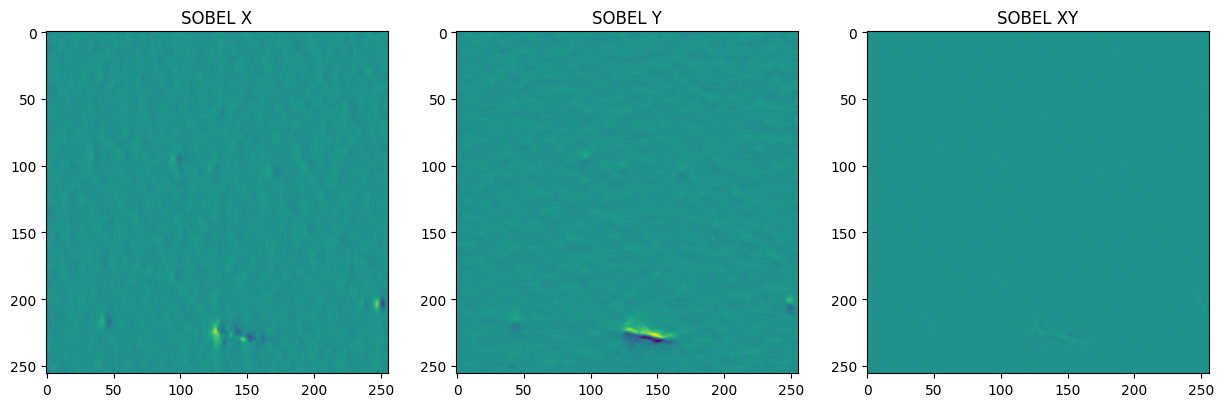

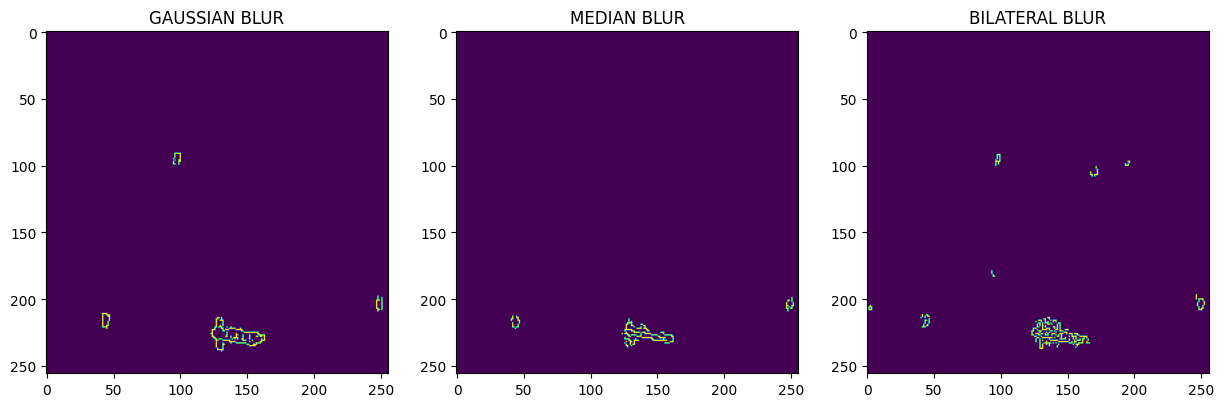

In [59]:
file_txt = file_jpg[:-3] + 'txt'
print(file_txt)
with open(file_txt, 'r') as file:
    file_content = file.read()
    print("Contents of the file:")
    print(file_content)
    ships_cnt = len(file_content.splitlines())
    print(f'The ships in the file are {ships_cnt}')

# Sobel edge detection with median blur
sobelx = cv2.Sobel(median_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)
sobely = cv2.Sobel(median_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5)
sobelxy = cv2.Sobel(median_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)

imshow_all(sobelx, sobely, sobelxy, titles=["SOBEL X",  "SOBEL Y", "SOBEL XY"])

# Canny edge detection with gaussian, median, and bilateral blur
canny_gaussian = cv2.Canny(gaussian_blur, 125, 175)
canny_median = cv2.Canny(median_blur, 125, 175)
canny_bilateral = cv2.Canny(bilateral_blur, 125, 175)

imshow_all(canny_gaussian, canny_median, canny_bilateral, titles=["GAUSSIAN BLUR",  "MEDIAN BLUR", "BILATERAL BLUR"])

## Segmentation

We tried K-MEANS clustering algorithm to apply segmentation to the image.

(65536, 1)
(256, 256)


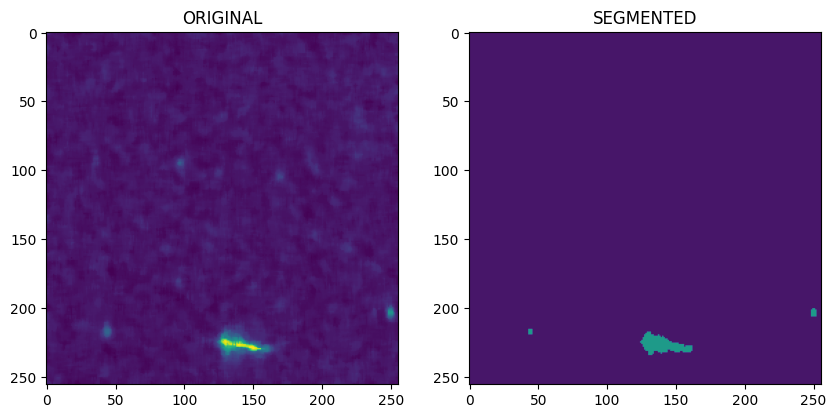

In [60]:
from sklearn.cluster import KMeans

original_image = median_blur
original_shape = original_image.shape
num_channels = 3 if len(original_shape) == 3 else 1

X = original_image.reshape(-1, num_channels)
print(X.shape)

k_means = KMeans(n_clusters=2, n_init=10)
k_means.fit(X)

segmented_img = k_means.cluster_centers_[k_means.labels_]
segmented_img = segmented_img.reshape(original_shape).astype(np.uint8)
print(segmented_img.shape)

imshow_all(original_image, segmented_img, titles=["ORIGINAL", "SEGMENTED"])


## Other

(256, 256, 3)


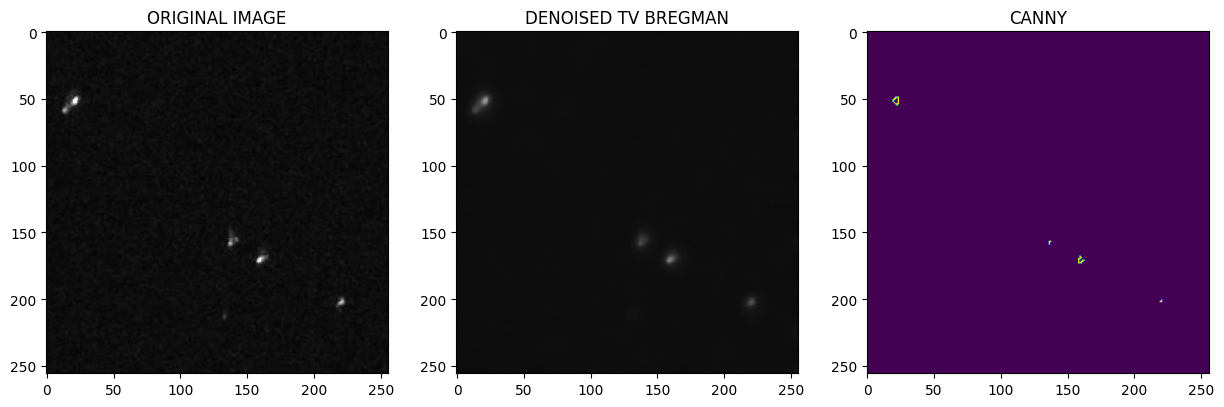

In [5]:
# other denoise filters

from skimage.restoration import denoise_tv_bregman
from skimage.morphology import disk
example_image = img
denoised = denoise_tv_bregman(example_image, 1)
d = disk(4)
#median = filters.rank.median(example_image, d)
titles = ['image', 'denoised', 'canny']

#canny
edges = cv2.Canny(example_image,600
                  ,750)

print(denoised.shape)

imshow_all(example_image, denoised, edges, titles=["ORIGINAL IMAGE",  "DENOISED TV BREGMAN", "CANNY"])





Random JPG file selected: ./ship_dataset_v0\Sen_ship_hh_02016092801054018.jpg
./ship_dataset_v0\Sen_ship_hh_02016092801054018.txt
Contents of the file:
0 0.869140625 0.748046875 0.19921875 0.20703125

(256, 256, 3)
['./ship_dataset_v0\\Sen_ship_hh_02016092801054018.jpg', 'denoised', 'canny']
Random JPG file selected: ./ship_dataset_v0\Gao_ship_hh_020170215800101109.jpg
./ship_dataset_v0\Gao_ship_hh_020170215800101109.txt
Contents of the file:
0 0.62890625 0.111328125 0.1015625 0.06640625
0 0.673828125 0.67578125 0.14453125 0.1484375
0 0.5234375 0.865234375 0.140625 0.13671875
0 0.83984375 0.509765625 0.125 0.12109375

(256, 256, 3)
['./ship_dataset_v0\\Gao_ship_hh_020170215800101109.jpg', 'denoised', 'canny']


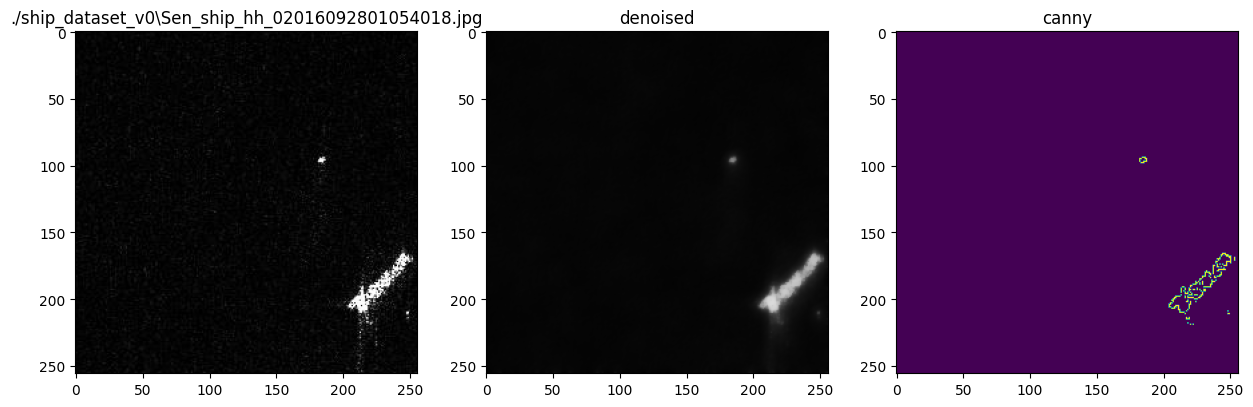

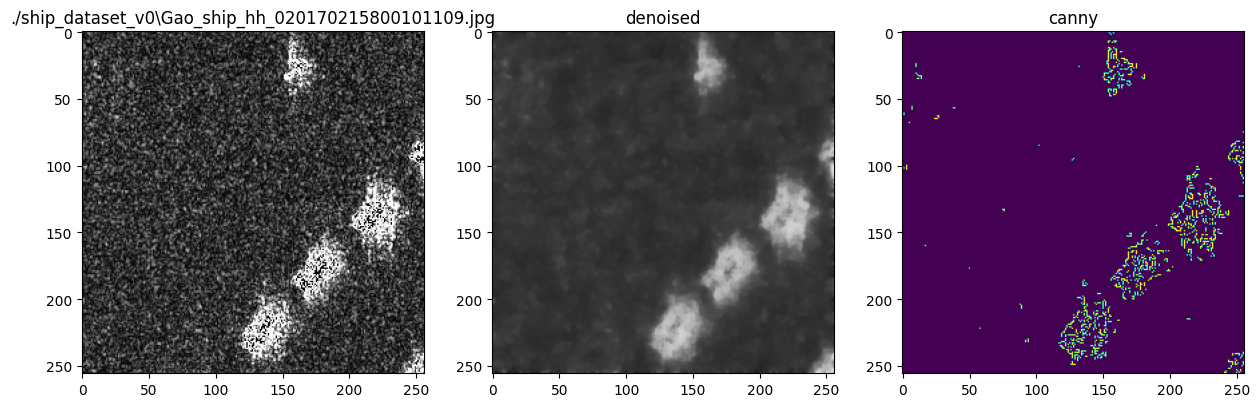

In [19]:
n_times = 2

for i in range(0, n_times):
    random_jpg_file = get_random_jpg_file()

    if random_jpg_file:
        print(f"Random JPG file selected: {random_jpg_file}")

        txt_file = random_jpg_file.replace(".jpg", ".txt")
        print(txt_file)
        with open(txt_file, 'r') as file:
            file_content = file.read()
            print("Contents of the file:")
            print(file_content)

        image=cv2.imread(random_jpg_file)
        denoised = denoise_tv_bregman(image, 1)
        d = disk(4)
        #median = filters.rank.median(example_image, d)
        titles = [random_jpg_file, 'denoised', 'canny']


        #canny
        # this parameters can be modified we have problems when we are dealing with a harbour and coastal areas 
        edges = cv2.Canny(image,600,750)

        print(denoised.shape)

        print(titles)
        imshow_all(image, denoised, edges, titles=titles)

In [8]:
'''
img = cv2.imread('./ship_dataset_v0/Gao_ship_hh_020170405960306013.jpg')
dst = cv2.fastNlMeansDenoising(img, None, 10)

# convert to gray
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# blur
#smooth = cv2.GaussianBlur(gray, (8,8), 0)

# smooth with bilateral filter to remove noise 
# https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed
smooth = cv2.bilateralFilter(img, 50, 200, 200)
# divide gray by morphology image
#division = cv2.divide(gray, smooth, scale=255)

canny_before = cv2.Canny(gray, 600, 750)
canny = cv2.Canny(smooth, 600, 750)

#sharp = filters.unsharp_mask(division, radius=1.5, amount=1.5, multichannel=False, preserve_range=False)
#sharp = (255*sharp).clip(0,255).astype(np.uint8)
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

test = denoise_bilateral(img, sigma_color=0.50, sigma_spatial=10,
                channel_axis=-1)

# TODO: try to use the canny on the test image
canny_on_test = cv2.Canny(test, 600, 750)
imshow_all(img, canny_before, dst, smooth, canny, canny_on_test)




#plt.subplot(154),plt.imshow(division)
#plt.subplot(155),plt.imshow(sharp)

plt.show()
'''

"\nimg = cv2.imread('./ship_dataset_v0/Gao_ship_hh_020170405960306013.jpg')\ndst = cv2.fastNlMeansDenoising(img, None, 10)\n\n# convert to gray\ngray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)\n# blur\n#smooth = cv2.GaussianBlur(gray, (8,8), 0)\n\n# smooth with bilateral filter to remove noise \n# https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed\nsmooth = cv2.bilateralFilter(img, 50, 200, 200)\n# divide gray by morphology image\n#division = cv2.divide(gray, smooth, scale=255)\n\ncanny_before = cv2.Canny(gray, 600, 750)\ncanny = cv2.Canny(smooth, 600, 750)\n\n#sharp = filters.unsharp_mask(division, radius=1.5, amount=1.5, multichannel=False, preserve_range=False)\n#sharp = (255*sharp).clip(0,255).astype(np.uint8)\nfrom skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,\n                                 denoise_wavelet, estimate_sigma)\n\ntest = denoise_bilateral(img, sigma_color=0.50, sigma_spatial=10,\n                chann

In [9]:
# TODO: given the latter we need to asses when the bilater filter is actually necessary and when it is not
# so we need to respond actually to this question: when we can define an image noisy?

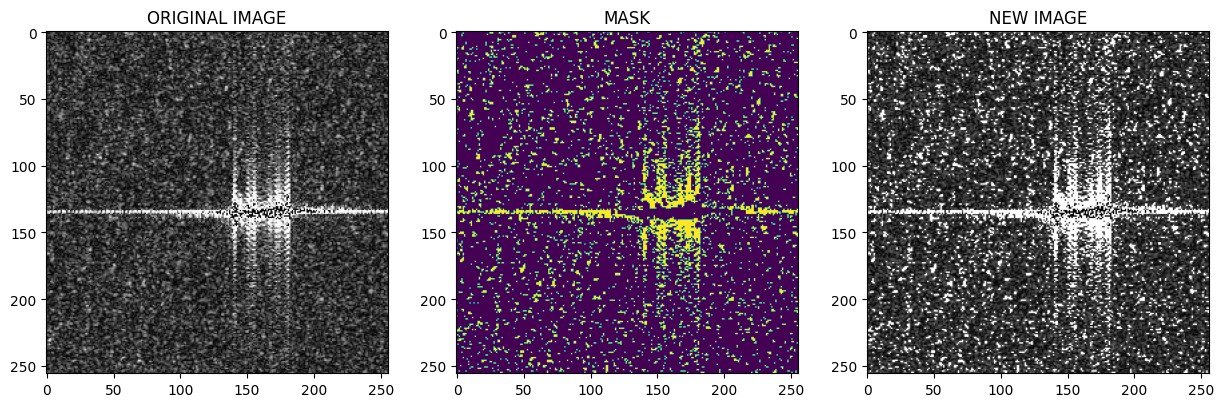

In [10]:
def test_remove_gray (img_path = "./ship_dataset_v0/Gao_ship_hh_020170405960306013.jpg"):

    img = cv2.imread(img_path)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(hsv, (0, 0, 100), (255, 5, 255))
    #cv2.imshow('mask before and with nzmask', mask);

    # Build mask of non black pixels.
    nzmask = cv2.inRange(hsv, (0, 0, 5), (255, 255, 255))

    # Erode the mask - all pixels around a black pixels should not be masked.
    nzmask = cv2.erode(nzmask, np.ones((3,3)))
    #cv2.imshow('nzmask', nzmask);

    mask = mask & nzmask

    new_img = img.copy()
    new_img[np.where(mask)] = 255
    return mask, new_img

mask, new_img = test_remove_gray()

imshow_all(cv2.imread("./ship_dataset_v0/Gao_ship_hh_020170405960306013.jpg"), mask, new_img, titles=["ORIGINAL IMAGE", "MASK", "NEW IMAGE"])

## CNN / Mask R-CNN / Faster R-CNN with object detection

In order to perform the detection after the pre-processing phase we are going to use the images to train a model and compute where the ship are inside the image.
In the final part we will discuss about the result of the CNN comparing the result using the two training dataset (the pre-processed one and the original dataset) to see if the behaviour of the NN changes.

TODO: maybe do a comparison between a YOLO, RetinaNet and Faster R-CNN

Rotatable boxes are used in order to have a better AP with CNN

MS COCO : 

mAP (mean Average Precision): comprehensive evaluation on ship detection and
instance segmentation

$$IoU  = \int \nabla u \cdot \nabla v~dx = \int_\Omega fv~dx


IoUmask =
Maskpd ∩ Maskgt
Maskpd ∪ Maskgt
$$




$$IoU_{mask} = \frac{Mask_{pd} \cup  Mask_{gt}}{Mask_{pd} \cap Mask_{gt}}

$$

In [99]:
# Function for verifying the ground truth of a given image

def verify_ground_truth(img_name):
    img = cv2.imread(BASE_DIR)
    # TODO

def get_bound_box(img_name):
    txt_file = img_name+".txt"
    #print(txt_file)
    try:
        with open(txt_file, 'r') as file:
            file_content = file.read()
            #print("Contents of the file:")

            # now we convert the actual string in a list of float
            #print("\nAfter the conversion:\n")
            a = list(map(float, file_content.split()))
            #print(type(a))
            #print(a)
    except FileNotFoundError:
        print("File not found or path is incorrect")

    return a

def visualize_bound_box(img_name = "not provided"):
    if img_name == "not provided":
        img_name = get_random_file()
    else:
        img_name = BASE_DIR+img_name

    bounds = multiply_array(get_bound_box(img_name), 256)
    #print(bounds)

    img = cv2.imread(img_name+".jpg")

    assert len(bounds)%5 == 0, "Incomplete bound length"

    for i in range(0, len(bounds), 5):
        category = bounds[i]
        x = bounds[i+1]
        y = bounds[i+2]
        w = bounds[i+3]
        h = bounds[i+4]

        x1 = int(x - w/2)
        y1 = int(y - h/2)
        x2 = int(x + w/2)
        y2 = int(y + h/2)

        #print(f"Category: {category}")
        #print(f"X: {x}")
        #print(f"Y: {y}")
        #print(f"W: {w}")
        #print(f"H: {h}")
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def multiply_array(arr, num):
    return [i * num  if (index % 5 != 0) else i for index, i in enumerate(arr)]
# Category of the ship
# normalized column value of the ship center in the chip
# normalized row value of the ship center
# normalized ship width 
# normalized ship length.
# EXAMPLE
# [0.0, 0.63671875, 0.52734375, 0.2109375, 0.0546875]

# this has more than one ship
#get_bound_box('Gao_ship_hh_02016082544040403')
#print_bound_box('Gao_ship_hh_02016082544040403')

def get_random_file():
    jpg_file = get_random_jpg_file()
    random_file = jpg_file.replace(".jpg", "")
    return random_file

# without parameters you will get a random image
visualize_bound_box()

# you can add the file name in order to select a specific image
# visualize_bound_box("Gao_ship_hh_02016082544040302")



## RESULTS
